# Group assignment on natural language processing

**Group members:** Suuraj Perpeli, Veikka Immonen

In this assignment we analyze performance of machine learning models
for natural language processing (NLP) tasks, using 🤗 Hugging Face.

## Install depencies

This notebook is designed to be used in Google Colab out-of-the-box (by definition of you don't have to do anything else outside of Colab session).
First, install required depencies by using pip...

In [2]:
!pip3 install -U -q datasets transformers accelerate bitsandbytes hnswlib peft wandb openai-whisper ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━

...and import them

In [3]:
import torch

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline,
                          BitsAndBytesConfig, TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling, AutoModel,
                          AutoProcessor)
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from huggingface_hub import login
import wandb

import hnswlib

import os
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm

from gensim.models.word2vec import Word2Vec

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import scipy
import io
import ffmpeg

import whisper

## Load the dataset

We chose the Medical Meadow Medical Flashcards dataset presented by Han et al. (2023) (paper [here](https://arxiv.org/pdf/2304.08247)). This is the first subset out of four published subsets, consisting of QA flashcards of medical based questions.

The dataset can be loaded using 🤗 Datasets.

In [4]:
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print('Structure of data: ', ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Structure of data:  DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


The data is a dictionary ```train``` as the key and another dictionary ```Dataset```  as the value, the keys of this dictinoary are ```features``` and ```num_rows```, features being one of the ```input```, ```output```, or ```instruction```.

The ```num_rows``` suggests that there are 33955 questions and answers with instructions respectively.

Let us have a look at how each one of these are:

In [ ]:
print(f'Input :', ds['train']['input'][0])
print(f'Output :', ds['train']['output'][0])
print(f'Instruction :', ds['train']['instruction'][0])

Input : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Output : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
Instruction : Answer this question truthfully


The ```input```'s are questions,

The ```output```'s are answers and,

The ```instruction```'s are the instructions to answer the questions.

The dataset has also few empty prompts. Let's remove them.

In [5]:
ds = ds.filter(lambda example: len(example['input']) > 0)
ds

Filter:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33547
    })
})

## Initial analysis on the data

Let's analyze the output sentences and the train a Word2Vec model by them.

First, lowercase the text, tokenizing based on spaces to prepare the text for training. Using regex, character `\W` removes the non word characters thereby removing the '+','/','-' that however could be good to keep.

In [ ]:
tokenized_sentences = [re.sub(r'\W', ' ', sentence).lower().split() for sentence in ds['train']['output']]

for i in tokenized_sentences[:5]:
  print(i)

print(f'Minimum sentence len: ', min([len(i)for i in tokenized_sentences]))
print(f'Maximum sentence len: ', max([len(i)for i in tokenized_sentences]))
print(f'Average sentence len: ', np.mean([len(i)for i in tokenized_sentences]))

['very', 'low', 'mg2', 'levels', 'correspond', 'to', 'low', 'pth', 'levels', 'which', 'in', 'turn', 'results', 'in', 'low', 'ca2', 'levels']
['low', 'estradiol', 'production', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggests', 'narcolepsy']
['pth', 'independent', 'hypercalcemia', 'which', 'can', 'be', 'caused', 'by', 'cancer', 'granulomatous', 'disease', 'or', 'vitamin', 'd', 'intoxication']
['the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'is', 'directly', 'related', 'to', 'ovarian', 'reserve', 'a', 'lower', 'level', 'indicates', 'a', 'lower', 'ovarian', 'reserve']
Minimum sentence len:  1
Maximum sentence len:  247
Average sentence len:  54.90207768205801


We can also visualize the "distribution" of lenght of tokenized sentences.

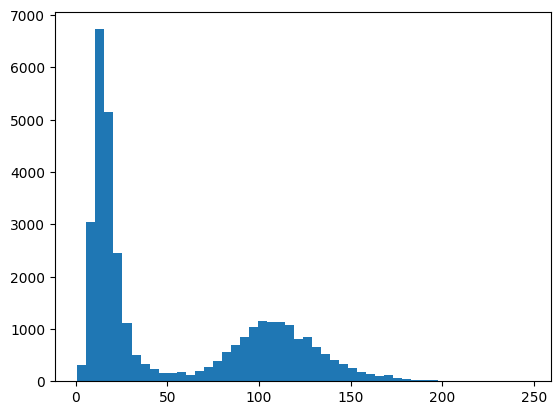

In [ ]:
plt.hist([len(sen) for sen in tokenized_sentences], 50)
plt.show()

Now let's train the Word2Vec on the ```outputs```.

In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=100, min_count=2, window=10)
print(f'Learnt vectors: ',len(model.wv))

Learnt vectors:  17676


One thing to try is to find most similar words using different terms.


In [ ]:
# term = 'sickness'
# term = 'fever'
# term = 'cure'
term = 'drugs'

sims = model.wv.most_similar(term, topn=5)
sims

[('agents', 0.8252885937690735),
 ('inhibitors', 0.7481815218925476),
 ('medications', 0.7263776659965515),
 ('drug', 0.7050749063491821),
 ('oxybutynin', 0.6653784513473511)]

## Retrieval-based chatbot

Let's build a QA chatbot based on a semantic search pipeline. Given a question
the bot tries to find a answer from a predefined corpus.

The model can be created by using SentenceTransformers.

In [15]:
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Create the corpus and use Approximate Nearest Neighbor (ANN) to speed-up the search using corpus embeddings.

In [7]:
index_path = './hnswlib.index'
corpus = np.array(ds['train']['output'][:])

if not os.path.exists(index_path):
  print("Creating a HNSWLIB index")
  corpus_embeddings = semb_model.encode(corpus, convert_to_tensor=True,
                                        show_progress_bar=True)
  index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))
  index.init_index(max_elements=corpus_embeddings.size(0),
                   ef_construction=256, M=64)
  index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
  print("Saving index to:", index_path)
  index.save_index(index_path)
else:
  empty_embeddings = semb_model.encode(corpus[:1], convert_to_tensor=True)
  index = hnswlib.Index(space='cosine', dim=empty_embeddings.size(1))
  index.load_index(index_path)


Creating a HNSWLIB index


Batches:   0%|          | 0/1049 [00:00<?, ?it/s]

Saving index to: ./hnswlib.index


Test the ranking using question encoder and ANN.

In [ ]:
sample = 3
query = ds['train']['input'][sample]
print(f'Query : {query}')
query_embedding = semb_model.encode(query, convert_to_tensor=True)
ids, distances = index.knn_query(query_embedding.cpu(), k=32)
out = ds['train']['output'][ids[0][np.argmin(distances[0])]]
print(f'Out : {out}')
print(f"True: {ds['train']['output'][sample]}")

Query : What are some possible causes of low PTH and high calcium levels?
Out : Secondary hyperparathyroidism can be caused by vitamin D deficiency in the case of low calcium, low phosphate, high PTH, and chronic kidney disease in the case of low calcium, high phosphate, high PTH.
True: PTH-independent hypercalcemia, which can be caused by cancer, granulomatous disease, or vitamin D intoxication.


Test the re-ranking using the cross-encoder.

In [ ]:
model_inputs = [(query, corpus[i]) for i in ids[0]]
cross_scores = xenc_model.predict(model_inputs)
print("Cross-encoder model re-ranking results")
print(f"Query: \"{query} \"")
print("-------------------------")
for idx in np.argsort(-cross_scores)[:5]:
  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{corpus[ids[0][idx]]}\"")

Cross-encoder model re-ranking results
Query: "What are some possible causes of low PTH and high calcium levels? "
-------------------------
Score: 7.0449
Document: "Low serum calcium levels will increase PTH levels in the bloodstream. PTH is a hormone produced by the parathyroid glands that helps regulate calcium levels in the body. When calcium levels in the blood drop too low, the parathyroid glands release more PTH to stimulate the release of calcium from the bones and increase its absorption from the intestines and kidneys. This helps raise blood calcium levels back to normal. However, if low calcium levels persist, it can lead to conditions such as osteoporosis and kidney stones."
Score: 6.9603
Document: "Hypercalcemia of malignancy is a condition in which there is an abnormally high level of calcium in the blood due to cancer. This condition is often associated with low levels of parathyroid hormone (PTH), which is typically responsible for regulating calcium levels in the body.

Generate the responce function.

Note that the function `chatbot` takes a list (or `np.array`) of questions. In case of one question, put it in a list.

In [9]:
def chatbot(questions, index=index, corpus=corpus, semb_model=semb_model, xenc_model=xenc_model, top_k=32):

    questions = np.array(questions)
    question_embedding = semb_model.encode(questions, convert_to_tensor=True).cpu()
    corpus_ids, _ = index.knn_query(question_embedding, k=top_k)

    answers = corpus[corpus_ids]
    questions = np.stack([questions for _ in range(top_k)], 1)
    pairs = np.stack([questions, answers], 2)

    scores = np.stack([xenc_model.predict(pair) for pair in pairs])
    idx = np.argmax(scores, 1, keepdims=True)
    answers = np.take_along_axis(answers, idx, 1).flatten()

    return answers

In [78]:
def retrive_context(query, semb_model=semb_model, index=index, n=1):
    query_embedding = semb_model.encode(query, convert_to_tensor=True)
    ids, distances = index.knn_query(query_embedding.cpu(), k=32)
    # context = ds['output'][ids[0][np.argsort(-distances[0]) ][:5] ]
    context_list = [corpus[i] for i in ids[0][:n]]
    context = ' '.join(context_list)
    return context

Test the chatbot.

In [ ]:
start, end = 0, 3000
questions = np.array(ds['train']['input'])[start:end]
true = corpus[start:end]

batch_size = 128
iterator = tqdm(range(0, len(questions), batch_size))
pred = np.concatenate([chatbot(questions[i: i+batch_size]) for i in iterator])

print((pred == true).mean())


100%|██████████| 24/24 [03:52<00:00,  9.68s/it]

0.7636666666666667


## Integrating speech-to-text and text-to-speech functionality

Load Whisper for S2T.

In [10]:
whisper_model = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:09<00:00, 53.7MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Load Bark for T2S

In [11]:
tts_utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [12]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please ope

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [13]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
scipy.io.wavfile.write('./tmp.wav', sr, audio)

In [ ]:
recording = whisper.load_audio("./tmp.wav")
recording = whisper.pad_or_trim(recording)

In [ ]:
mel = whisper.log_mel_spectrogram(recording).to(whisper_model.device)

# Use the mel spectrogram to detect the language
_, probs = whisper_model.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: fi, confidence: 0.9561903476715088


In [ ]:
# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(whisper_model, mel, options)

# print the recognized text
print(result.text)


Testing testing 123.


In [ ]:
sequences, lengths = tts_utils.prepare_input_sequence([result.text])
sequences

tensor([[57, 42, 56, 57, 46, 51, 44, 11, 57, 42, 56, 57, 46, 51, 44, 11, 52, 51,
         42, 11, 45, 58, 51, 41, 55, 42, 41, 11, 57, 60, 42, 51, 57, 62,  1, 57,
         45, 55, 42, 42,  7]], device='cuda:0')

In [ ]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel).cpu().numpy().squeeze()

In [ ]:
len(audio)

52224

In [ ]:
rate = 23000
print(text)
Audio(audio, rate=rate)

Hypercalcemia of malignancy is a condition in which there is an abnormally high level of calcium in the blood due to cancer. This condition is often associated with low levels of parathyroid hormone (PTH), which is typically responsible for regulating calcium levels in the body. Low PTH levels in hypercalcemia of malignancy may be due to the production of other hormones by cancer cells that mimic the effects of PTH, or to the direct effect of cancer on bone tissue, leading to the release of calcium into the bloodstream. Treatment for hypercalcemia of malignancy may involve addressing the underlying cancer, as well as medications to lower calcium levels and manage symptoms.


In [ ]:
scipy.io.wavfile.write('./tmp.wav', rate, audio_numpy)

In [14]:
def s2s_chatbot(rate=23000, method='zero'):

    input_audio, input_rate = get_audio()
    scipy.io.wavfile.write('./tmp.wav', input_rate, input_audio)

    recording_in = whisper.load_audio("./tmp.wav")
    recording_in = whisper.pad_or_trim(recording_in)

    mel = whisper.log_mel_spectrogram(recording_in).to(whisper_model.device)
    options = whisper.DecodingOptions(fp16=False, language='en')
    result = whisper.decode(whisper_model, mel, options)

    # if method == 'zero':
    answer = chatbot([result.text])

    audios = []
    for sentence in re.split(r'\. |, ', answer[0]):
        sequences, lengths = tts_utils.prepare_input_sequence([sentence])
        with torch.no_grad():
            mel, _, _ = tacotron2.infer(sequences, lengths)
            audio = waveglow.infer(mel).cpu().numpy().squeeze()
        audios.append(audio)
    audio = np.concatenate(audios)

    return result.text, answer[0], Audio(audio, rate=rate)


In [ ]:
sample = ds['train'][0]
print(sample['input'])
print(sample['output'])

What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [ ]:
question_text, answer_text, answer_audio = s2s_chatbot()
print(question_text)
print(answer_text)
answer_audio

What happened if there was a blue shocker?
Shock is a medical emergency that occurs when there is inadequate organ perfusion and delivery of nutrients necessary for normal tissue and cellular function. It is a life-threatening condition that can result from a variety of causes, including severe bleeding, heart failure, severe infection, or anaphylaxis. The inadequate delivery of oxygen and nutrients to the body's organs and tissues can lead to organ failure and even death if not promptly treated. Treatment for shock may involve identifying and addressing the underlying cause, administering fluids and medications to support blood pressure and organ function, and in some cases, surgery.


## Generative Chatbot

Download the model and tokenizer, model as quantized

In [1]:
!unzip ft_model-v1.zip

Archive:  ft_model-v1.zip
   creating: finedtuned_model/
  inflating: finedtuned_model/training_args.bin  
  inflating: finedtuned_model/vocab.json  
  inflating: finedtuned_model/adapter_model.safetensors  
  inflating: finedtuned_model/tokenizer_config.json  
  inflating: finedtuned_model/adapter_config.json  
  inflating: finedtuned_model/special_tokens_map.json  
  inflating: finedtuned_model/README.md  
  inflating: finedtuned_model/tokenizer.json  
  inflating: finedtuned_model/merges.txt  


In [16]:
name = "gpt2"

In [17]:
tokenizer = AutoTokenizer.from_pretrained(name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [105]:
name = './finedtuned_model'
# name = 'gpt2'

In [62]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(name, device_map="auto",
                                             bos_token_id=tokenizer.bos_token_id,
                                             eos_token_id=tokenizer.eos_token_id,
                                             quantization_config=quantization_config)

In [23]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=768, out_features=2304, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear4bit(
            (base_l

In [103]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [104]:
generation_args = {
    "max_new_tokens": 200,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

prompt = """Instruction: Answer this question truthfully, in only one sentence.

Question: {}"""

def chatbot_zeroshot(question, pipe=pipe):
  message = prompt.format(question)
  out = pipe(message, **generation_args)

  return message + out[0]['generated_text']

In [84]:
context_prompt = """Instruction: Answer this question truthfully, using given context.

{}

Question: {}"""

def chatbot_with_context(question, pipe=pipe, n_context=1):
  context = retrive_context(question, n=n_context)
  message = context_prompt.format(context, question)
  out = pipe(message, **generation_args)
  return message + out[0]['generated_text']

In [107]:
instructions = """Instruction: Answer this question truthfully."""

shot_prompt = """Question: {}

Answer: {}"""

question_prompt = """Question {}"""

def chatbot_fewshot(question, seed=0, shots=1, pipe=pipe):
  np.random.seed(seed)
  idx = np.random.choice(np.arange(len(corpus)), shots, replace=False).tolist()
  message = instructions + "\n\n"
  message += "\n\n".join(
      [shot_prompt.format(ds['train'][id]['input'], ds['train'][id]['output'])
       for id in idx[:-1]])
  message += "\n\n" + question_prompt.format(ds['train'][idx[-1]]['input'])
  out = pipe(message, **generation_args)
  return message + out[0]['generated_text']


In [102]:
out = chatbot_zeroshot(ds['train'][0]['input'])
print(out)

Question What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Question What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels? Very low Mg2+ levels are associated with low Ca2+ levels, while high Ca2+ levels are associated with high Ca2+ levels. This means that the body is reacting to low levels of calcium in the blood, which can lead to a decrease in calcium levels. However, it is important to note that the exact relationship between low levels of calcium and low levels of Ca2+ is not well understood, and it is important to note that the exact relationship between low levels of calcium and high levels of Ca2+ is not well understood. It is important to note that the exact relationship between low levels of calcium and high levels of Ca2+ is not well understood, and it is important to note that the exact relationship between low levels of calcium and high levels of Ca2+ is not well understood. It is important to note that the e

In [83]:
out = chatbot_with_context(ds['train'][0]['input'], n_context=3)
print(out)

Instruction: Answer this question truthfully, using given context.

Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels. The actions of PTH are coordinated to produce an increase in serum Ca2+ and a decrease in serum phosphate (PO43-) levels. A severe decrease in serum Mg2+ concentration causes a decrease in PTH secretion. PTH (parathyroid hormone) is a hormone that regulates calcium and phosphate homeostasis in the body. When magnesium levels are low, PTH secretion decreases, which can lead to hypocalcemia (low calcium levels) and other related disorders.

Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Instruction: Answer this question truthfully, using given context.

Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels. The actions of PTH are coordinated to produce an increase in serum Ca2+ and a decrease in serum phosphate (PO43-) levels. A severe decrease in 

In [109]:
out = chatbot_fewshot(ds['train'][0]['input'], seed=1, shots=3)
print(out)

Instruction: Answer this question truthfully.

Question: What is the name of the immunodeficiency that is characterized by the absence of B-cell differentiation and decreased immunoglobulins of all classes?

Answer: The immunodeficiency that is characterized by the absence of B-cell differentiation and decreased immunoglobulins of all classes is called common variable immunodeficiency (CVID). CVID is a rare disorder that affects the immune system and is characterized by low levels of antibodies (immunoglobulins) in the blood. B cells are a type of white blood cell that differentiate into plasma cells, which produce antibodies. In individuals with CVID, B cells fail to differentiate into plasma cells, resulting in a reduced ability to fight infections. This leads to decreased immunoglobulins of all classes. The exact cause of CVID is unknown, but it is thought to be due to a combination of genetic and environmental factors. Treatment for CVID involves regular infusions of immunoglobulin

Conclusion: **MEDICAL ATTENTION IS ALL YOU NEED**

Format data for training

In [ ]:
alpaca_prompt = """Instruction: {}

Question: {}

Answer: {}"""

def format(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {"text": texts}


ds = ds.map(format, batched=True)

print(ds)
print(ds['train']['text'][0])

Map:   0%|          | 0/33547 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'text'],
        num_rows: 33547
    })
})
Instruction: Answer this question truthfully

Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Answer: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


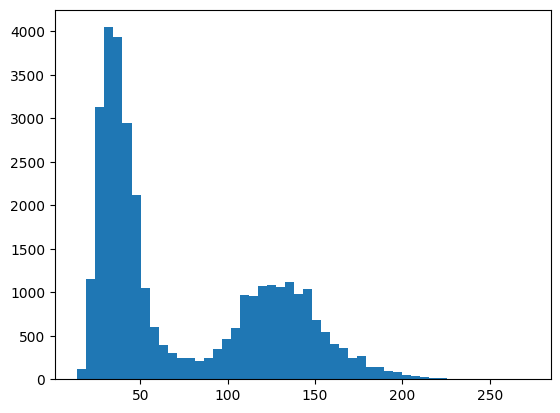

In [ ]:
plt.hist([len(sample['text'].split()) for sample in ds['train']], 50)
plt.show()

In [ ]:
max_length = 400

def tokenize(examples):
    inputs = tokenizer(examples["text"], truncation=True,
                       max_length=max_length, return_overflowing_tokens=True)
    return inputs

ds_encoded = ds.map(tokenize, batched=True, remove_columns=ds["train"].column_names)
ds_encoded

Map:   0%|          | 0/33547 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 33547
    })
})

Create LoRA configuration for QLoRA

In [ ]:
adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 2,
    'lora_dropout': 0.05,
    'r': 4,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

prepared_model_4bit = prepare_model_for_kbit_training(model)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

qlora_model.print_trainable_parameters()

trainable params: 589,824 || all params: 125,029,632 || trainable%: 0.4717


In [ ]:
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
wandb.init(mode="disabled")

In [ ]:
sample = [ds_encoded['train'][i]['input_ids'] for i in range(1)]
collated = data_collator(sample)

print(collated.keys())

dict_keys(['input_ids', 'labels'])


In [ ]:
train_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=16,
    learning_rate=1e-4,
    bf16=True,
    logging_steps=4,
    output_dir="outputs",
)
trainer = Trainer(
    model=qlora_model,
    processing_class=tokenizer,
    train_dataset=ds_encoded['train'],
    args=train_args,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,2.936100
2,2.922100
3,2.944300
4,2.940600
5,2.957400
6,2.940800
7,2.955100
8,2.951500
9,2.983400
10,2.912200


TrainOutput(global_step=65, training_loss=2.9433239790109487, metrics={'train_runtime': 3295.9664, 'train_samples_per_second': 10.178, 'train_steps_per_second': 0.02, 'total_flos': 3937540036902912.0, 'train_loss': 2.9433239790109487, 'epoch': 0.9918931807343825})

In [ ]:
print(chatbot_zeroshot(ds['train'][0]['input'], model=qlora_model))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Let's be honest with you. If you are working for any reason, know how you make a living from a life of simple stuff, you should read this post this post to help you with that. All of that is required knowledge from being a professional that does not involve having a professional
So, what is going on? Yes, you can see a small change, but substantial, drop in to the real value is going to the other side as long as the person isn't going
